# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generating figure 3. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

In [33]:
#import modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [34]:
file = pandas.read_excel('statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård") #load admissions
data = [['Sthlm', 8], ['VGR', 9], ['Skåne', 10],['Östergötland',11],['Jönköping',12],['Södermanland',13],['Uppsala',14],['Gävelborg',15],['Västmanland',16],['Örebro',17],['Norrbotten',18],['Dalarna',19],['Västernorrland',20],['Värmland',21],['Halland',22],['Kalmar',23],['Kronoberg',24],['Västerbotten',25],['Jämtland',26],['Blekinge',27],['Gotland',28]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index']) 
vald_region='Skåne' #pick out data for Skåne
temp=regioner.loc[regioner['region']==vald_region] 
index=temp['index'].values
R = file.iloc[index[0]] 
R=R.replace(' ','X') #replace missing data with 0
R=R.replace('X',0) 
ind = np.arange(3,len(R),2)
I = R.iloc[ind].values 
I=np.insert(I,0,[0,0,0,0]) #add data before first admission
I=I[:-1]
veckor = np.arange(0,len(I),1) 

In [35]:
#Parameters
startvecka=10-4 #first week with case data minus the padding
Tmax=53 #length of prediction
N=1725881 #population of Skåne
pv=0.023 #fraction of cases that are admitted

rho=7*1/5.1 #incubation rate
gamma=7*1/5 #recovery rate

delay=3 #time from infection to admission

In [37]:
#Load data from Skånetrafiken
df = pandas.read_excel('ST.xlsx') 
diff = df['Förändring'].values
T=np.arange(6,6+len(diff),1) 

In [38]:
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function

In [39]:
#time-dependent infectivity
def beta(t,a,b):
    return a+b*resfkn(t)

In [40]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b)*x3/N
    dx2 = x1*beta(t-lag,a,b)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    
    return [dx1, dx2, dx3, dx4]

In [10]:
#define outdata from model
def pred_inlagda(t,a,b,lag):
    x0 = [N-1,0,1,0] #initial conditions
    x = odeint(dx, x0, t,args=(a,b,lag))
    return pv*x[:,2]

In [41]:
#performing global grid search
#For better parameter estimates this can be rerun with higher value of n around the expected optimum
I_train=I
veckor_train=veckor
n=10
ah=np.linspace(3,5,n)
bh=np.linspace(4,6,n)

E=np.zeros((len(ah),len(bh)))
for i in range(n):
    print(i)
    for j in range(n):
        P=pred_inlagda(veckor_train,ah[i],bh[j],delay)
        E[i,j]=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))

0
1
2
3
4
5
6
7
8
9


In [43]:
#find parameters with smallest error
optind = np.where(E == np.amin(E))
afit = ah[optind[0]]
bfit = bh[optind[1]]

print("Minimum RMSE: ",E[optind])
print("a=",afit,"b=",bfit)

Minimum RMSE:  [39.20188334]
a= [3.66666667] b= [4.66666667]


In [44]:
#local search
I_train=I
veckor_train=veckor
fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[12,12,3+0.001]),p0=(afit,bfit,3))

In [45]:
P=pred_inlagda(veckor_train,fit[0],fit[1],delay)
E=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))
print("Model error (RMSE)=",E,"admissions/week")

Model error (RMSE)= 21.395164763722164 admissions/week


In [46]:
#Genererate confidence interval
M=100
t=np.linspace(0,Tmax-startvecka,200)
P=np.zeros((M,int(len(t))))
perr = np.sqrt(np.diag(cov))
for i in range(M):
    a_r = np.random.normal(fit[0],perr[0],1)
    b_r = np.random.normal(fit[1],perr[1],1)
    P[i,:]=pred_inlagda(t,a_r,b_r,delay)
Pu=np.percentile(P,97.5,axis=0)
Pl=np.percentile(P,2.5,axis=0)

Text(0.5, 1.0, 'Skåne')

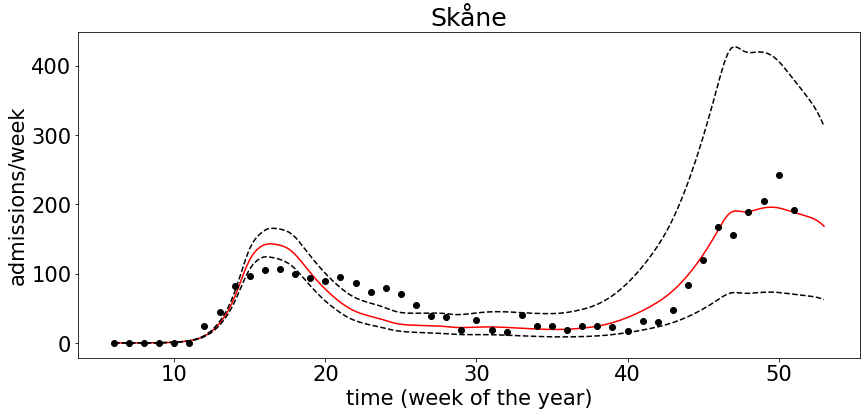

In [47]:
#plot results
t=np.linspace(0,Tmax-startvecka,200)

fig, axes = plt.subplots(1,1,figsize=(14,6))
pred = pred_inlagda(t,fit[0],fit[1],delay)

axes.plot(t+startvecka,pred,'r',label="Prediktion med resor")
axes.plot(t+startvecka,Pu,'k--',label="Prediktion med resor")
axes.plot(t+startvecka,Pl,'k--',label="Prediktion med resor")

axes.plot(veckor+startvecka,I,'b.',label="Inlagda")
axes.plot(veckor_train+startvecka,I_train,'ko',label="Inlagda")

axes.set_xlabel('time (week of the year)')
axes.set_ylabel('admissions/week')
axes.set_title('Skåne')

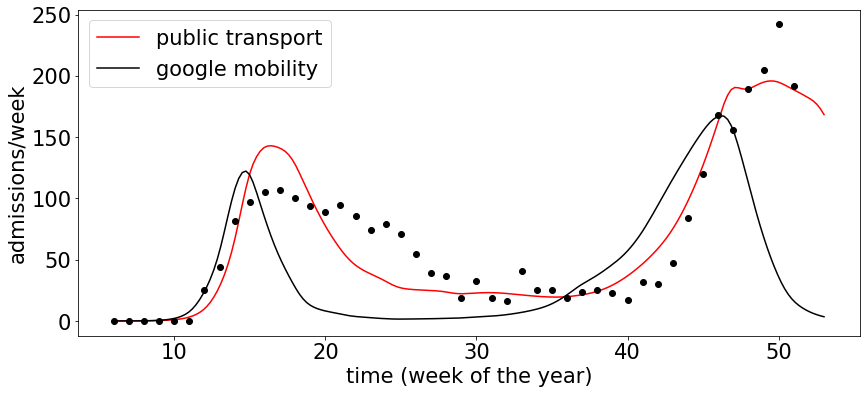

In [48]:
#Load model fit using Google data
predg, tg = np.load('skane.npy',allow_pickle = True)
fig, axes = plt.subplots(1,1,figsize=(14,6))
pred = pred_inlagda(t,fit[0],fit[1],delay)

#plot result and save figure
axes.plot(t+startvecka,pred,'r',label="public transport")
axes.plot(tg+startvecka,predg,'k',label="google mobility")
        
axes.plot(veckor+startvecka,I,'ko')

axes.set_xlabel('time (week of the year)')
axes.set_ylabel('admissions/week')
axes.legend()
fig.savefig("Skåne_jmfr.pdf",format='pdf')